# Notebook de comparaison et d'analyse

Ce notebook compare deux jeux de données: `intent_mapped_with_elo.jsonl` (référence) et `augmented.jsonl` (augmenté). Objectifs:
1. Statistiques globales & structure.
2. Répartition & couverture des intents (discret / continu).
3. Diversité textuelle & richesse lexicale.
4. Doublons & quasi-doublons intra / inter.
5. Similarité sémantique & clustering (optionnel si modèles disponibles).
6. Synthèse + recommandations actionnables.

---
Les sections suivantes implémentent l'outline défini.

## 1. Configuration & Imports
Préparation de l'environnement: chemins, graine, options pandas, imports robustes avec gestion des dépendances optionnelles.

In [1]:
# Configuration & Imports
from __future__ import annotations
import os, sys, json, math, re, statistics, random, string
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from dataclasses import dataclass
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Optionnels / best-effort
try:
    from rapidfuzz import fuzz
    HAVE_RAPIDFUZZ = True
except ImportError:
    HAVE_RAPIDFUZZ = False
try:
    from datasketch import MinHash, MinHashLSH
    HAVE_DATASKETCH = True
except ImportError:
    HAVE_DATASKETCH = False
try:
    from sentence_transformers import SentenceTransformer
    import torch
    HAVE_ST = True
except Exception:
    HAVE_ST = False
try:
    import umap
    HAVE_UMAP = True
except ImportError:
    HAVE_UMAP = False
try:
    import hdbscan
    HAVE_HDBSCAN = True
except ImportError:
    HAVE_HDBSCAN = False

pd.set_option('display.max_colwidth', 160)
pd.set_option('display.min_rows', 10)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Définition BASE: dossier parent nommé 'Agent_Dataaug'
cwd = Path.cwd().resolve()
for p in [cwd] + list(cwd.parents):
    if p.name == 'Agent_Dataaug':
        BASE = p
        break
else:
    # Fallback si non trouvé (logique initiale)
    BASE = cwd.parent if cwd.name == 'notebook' else cwd
DATA_MAPPED = BASE / 'intent_mapped_with_elo.jsonl'
DATA_AUG = BASE / 'augmented.jsonl'
OUTPUT_DIR = BASE / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

print('Version pandas:', pd.__version__)
print('RapidFuzz:', HAVE_RAPIDFUZZ, '| Datasketch:', HAVE_DATASKETCH, '| SentenceTransformer:', HAVE_ST)
print('UMAP:', HAVE_UMAP, '| HDBSCAN:', HAVE_HDBSCAN)


/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version pandas: 2.3.0
RapidFuzz: False | Datasketch: True | SentenceTransformer: True
UMAP: True | HDBSCAN: True


## 2. Chargement des Deux Datasets
Lecture robuste JSONL ligne à ligne, ajout d'une colonne `source` pour différencier.

In [2]:
def read_jsonl(path: Path, source_label: str) -> pd.DataFrame:
    records = []
    with path.open('r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                obj['__line__'] = i
                obj['source'] = source_label
                records.append(obj)
            except json.JSONDecodeError as e:
                print(f"[WARN] Ligne {i} ignorée: {e}")
    return pd.DataFrame(records)

mapped_df = read_jsonl(DATA_MAPPED, 'mapped')
aug_df = read_jsonl(DATA_AUG, 'augmented')
print('Tailles initiales:', len(mapped_df), len(aug_df))

mapped_df.head(2), aug_df.head(2)

Tailles initiales: 2082 1592


(           id dataset                               prompt  \
 0  URS_000000     URS                      如何提高民营企业的市场竞争力？   
 1  URS_000001     URS  跳舞和骑车时哪个更合适，Apple Watch还是Oura Ring？   
 
                                                                                                                                                           response  \
 0  提高民营企业的市场竞争力，可以从以下几个方面入手：\n\n1. **创新与研发**：持续投入研发，推出创新产品或服务，以技术创新作为核心竞争力。\n\n2. **人才培养和引进**：构建具有竞争力的薪酬福利体系，吸引和保留优秀人才，同时加大对员工的培训力度，提高团队整体素质。\n\n3. **提升品牌价值**：...   
 1  对于跳舞和骑车这两项活动，Apple Watch会比Oura Ring更加合适。理由如下：\n\n1. **实时反馈**：Apple Watch能够提供实时的健身追踪和反馈，如心率、消耗的卡路里及活动时间等，这对于跳舞和骑车这类需要及时调整强度的活动尤其重要。\n\n2. **多功能性**：除了健康和活动追踪之...   
 
    intent_disc  intent_cont intent_source  original_label language  __line__  \
 0            2        0.062    mapped_URS  Ask_for_Advice       CN         0   
 1            2        0.062    mapped_URS  Ask_for_Advice       CN         1   
 
    source  
 0  mapped  
 1  mapped  ,
                     

## 3. Normalisation & Préparation
Uniformisation des colonnes critiques et nettoyage (espaces, types, id manquants, détection langue heuristique).

In [3]:
def detect_lang(text: str) -> str:
    if text is None or not isinstance(text, str):
        return 'unk'
    # heuristique simple: présence de caractères CJK
    if re.search('[\u4e00-\u9fff]', text):
        return 'CN'
    # présence de lettres accentuées -> supposer FR sinon EN
    if re.search('[àâçéèêëîïôûùüÿñæœ]', text.lower()):
        return 'FR'
    return 'EN'

def normalise(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Normaliser colonnes attendues
    if 'id' not in df.columns:
        df['id'] = [f"gen_{i}" for i in range(len(df))]
    for col in ['prompt', 'response']:
        if col not in df.columns:
            df[col] = None
    # Types
    if 'intent_disc' in df.columns:
        df['intent_disc'] = pd.to_numeric(df['intent_disc'], errors='coerce').astype('Int64')
    else:
        df['intent_disc'] = pd.NA
    if 'intent_cont' in df.columns:
        df['intent_cont'] = pd.to_numeric(df['intent_cont'], errors='coerce')
    else:
        df['intent_cont'] = np.nan
    # Trim
    for col in ['prompt','response']:
        df[col] = df[col].astype(str).str.strip()
    # Langue
    if 'language' not in df.columns:
        df['language'] = df['prompt'].map(detect_lang)
    else:
        df['language'] = df['language'].fillna(df['prompt'].map(detect_lang))
    # Suppression doublons stricts
    before = len(df)
    df = df.drop_duplicates(subset=['prompt','response','source'])
    print(f"Suppression doublons stricts: {before-len(df)} lignes retirées")
    return df.reset_index(drop=True)

mapped_n = normalise(mapped_df)
aug_n = normalise(aug_df)
all_df = pd.concat([mapped_n, aug_n], ignore_index=True)
print('Total combiné:', len(all_df))
all_df.head(3)

Suppression doublons stricts: 0 lignes retirées
Suppression doublons stricts: 0 lignes retirées
Total combiné: 3674


,id,dataset,prompt,response,intent_disc,intent_cont,intent_source,original_label,language,__line__,source
0,URS_000000,URS,如何提高民营企业的市场竞争力？,提高民营企业的市场竞争力，可以从以下几个方面入手：\n\n1. **创新与研发**：持续投入研发，推出创新产品或服务，以技术创新作为核心竞争力。\n\n2. **人才培养和引进**：构建具有竞争力的薪酬福利体系，吸引和保留优秀人才，同时加大对员工的培训力度，提高团队整体素质。\n\n3. **提升品牌价值**：...,2,0.062,mapped_URS,Ask_for_Advice,CN,0,mapped
1,URS_000001,URS,跳舞和骑车时哪个更合适，Apple Watch还是Oura Ring？,对于跳舞和骑车这两项活动，Apple Watch会比Oura Ring更加合适。理由如下：\n\n1. **实时反馈**：Apple Watch能够提供实时的健身追踪和反馈，如心率、消耗的卡路里及活动时间等，这对于跳舞和骑车这类需要及时调整强度的活动尤其重要。\n\n2. **多功能性**：除了健康和活动追踪之...,2,0.062,mapped_URS,Ask_for_Advice,CN,1,mapped
2,URS_000002,URS,日常补充剂的推荐摄入量是多少？,推荐的日常补充剂摄入量因年龄、性别、健康状况和特定需求而异。以下是几种常见补充剂的大致指导量：\n\n1. **维生素D**: 成人每日推荐400-800 IU（国际单位），但许多专家推荐每日1000-2000 IU以优化血液中的维生素D水平。\n\n2. **Omega-3脂肪酸（如鱼油）**: 对于心脏健康...,2,0.062,mapped_URS,Ask_for_Advice,CN,2,mapped


## 4. Statistiques Globales Comparatives
Comparaison de structure, valeurs manquantes, longueurs, etc.

     dataset  rows  cols  missing_prompt_pct  missing_response_pct  \
0     mapped  2082    11                 0.0                   0.0   
1  augmented  1592     9                 0.0                   0.0   

   len_prompt_mean  len_response_mean  response_missing_ratio  
0        95.075408        1276.451969                     0.0  
1       115.839196           4.000000                     1.0  


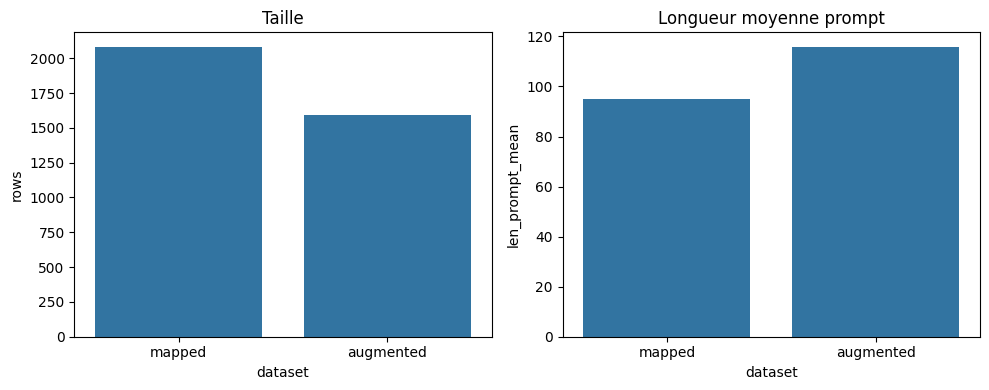

In [4]:
def global_stats(df: pd.DataFrame, name: str) -> dict:
    stats = {}
    stats['dataset'] = name
    stats['rows'] = len(df)
    stats['cols'] = len(df.columns)
    stats['missing_prompt_pct'] = df['prompt'].isna().mean()*100
    stats['missing_response_pct'] = df['response'].isna().mean()*100
    stats['len_prompt_mean'] = df['prompt'].astype(str).str.len().mean()
    stats['len_response_mean'] = df['response'].astype(str).str.len().mean()
    stats['response_missing_ratio'] = (df['response'].eq('None') | df['response'].isna()).mean()
    return stats

gs = pd.DataFrame([
    global_stats(mapped_n,'mapped'),
    global_stats(aug_n,'augmented')
])
print(gs)

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(gs, x='dataset', y='rows', ax=ax[0])
sns.barplot(gs, x='dataset', y='len_prompt_mean', ax=ax[1])
ax[0].set_title('Taille')
ax[1].set_title('Longueur moyenne prompt')
plt.tight_layout()
plt.show()

## 5. Répartition des Intents (discret & continu)
Analyse des distributions `intent_disc` et `intent_cont` (binning, entropie, visualisations).

,intent_disc,freq,dataset
0,0,600,mapped
1,1,205,mapped
2,2,1005,mapped
3,3,222,mapped
4,4,50,mapped


,intent_disc,freq,dataset
0,0,231,augmented
1,1,412,augmented
2,2,51,augmented
3,3,440,augmented
4,4,458,augmented


     dataset  unique_intents  entropy_intent_disc
0     mapped               5             1.827317
1  augmented               5             2.097655

Binning quantiles mapped
intent_cont
(-0.24, -0.225]    580
(0.011, 0.027]     537
(0.027, 0.062]     269
(0.09, 0.141]      222
(-0.133, 0.011]    205
Name: count, dtype: int64

Binning quantiles augmented
intent_cont
(0.011, 0.133]       509
(0.133, 0.153]       436
(-0.224, -0.0313]    380
(-0.24, -0.224]      227
(-0.0313, 0.011]      36
Name: count, dtype: int64


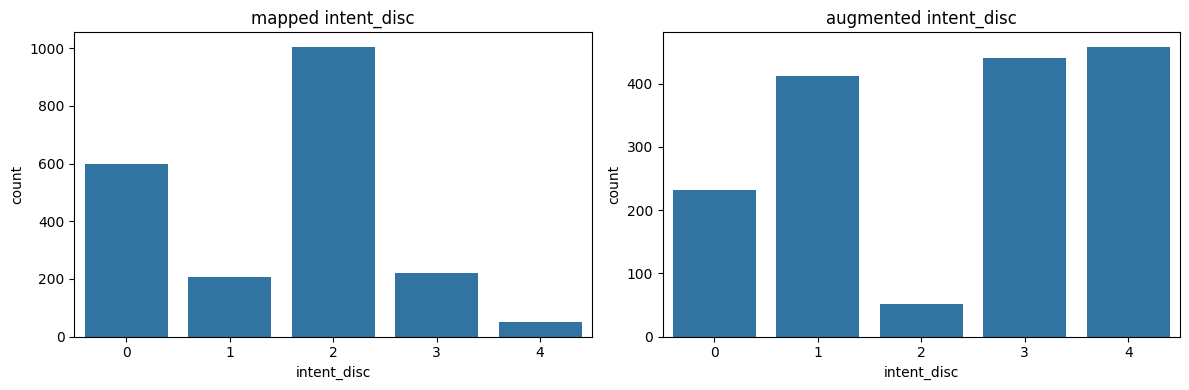

In [5]:
from math import log2

def entropy(counts: Counter) -> float:
    total = sum(counts.values())
    if total == 0: return 0.0
    return -sum((c/total)*log2(c/total) for c in counts.values() if c>0)

intent_disc_stats = []
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    c = Counter(df['intent_disc'].dropna().tolist())
    intent_disc_stats.append({'dataset':name,'unique_intents': len(c), 'entropy_intent_disc': entropy(c)})
    s = (pd.Series(c).sort_index())
    display(pd.DataFrame({'intent_disc': s.index, 'freq': s.values, 'dataset': name}))

disp_df = pd.DataFrame(intent_disc_stats)
print(disp_df)

# intent_cont binning
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    cont = df['intent_cont'].dropna()
    if len(cont) == 0:
        print(name, 'pas de intent_cont')
        continue
    bins = pd.qcut(cont, q=min(10, len(cont)), duplicates='drop')
    print('\nBinning quantiles', name)
    print(bins.value_counts().head())

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(mapped_n, x='intent_disc', ax=axes[0]); axes[0].set_title('mapped intent_disc')
sns.countplot(aug_n, x='intent_disc', ax=axes[1]); axes[1].set_title('augmented intent_disc')
plt.tight_layout()
plt.show()

## 6. Couverture & Nouveaux Intents Introduits
Identification des intents exclusifs / communs et couverture mutuelle.

In [6]:
mapped_ints = set(mapped_n['intent_disc'].dropna().unique())
aug_ints = set(aug_n['intent_disc'].dropna().unique())
new_in_aug = aug_ints - mapped_ints
missing_in_aug = mapped_ints - aug_ints
print('Intents nouveaux (augmented):', new_in_aug)
print('Intents manquants côté augmented vs mapped:', missing_in_aug)
print('Couverture mapped->aug (%):', 100*len(mapped_ints & aug_ints)/ (len(mapped_ints) or 1))

# Table croisée fréquences
freq_m = mapped_n['intent_disc'].value_counts().rename('freq_mapped')
freq_a = aug_n['intent_disc'].value_counts().rename('freq_augmented')
intent_freq = pd.concat([freq_m, freq_a], axis=1).fillna(0).astype(int)
intent_freq['delta'] = intent_freq['freq_augmented'] - intent_freq['freq_mapped']
intent_freq.sort_index()

Intents nouveaux (augmented): set()
Intents manquants côté augmented vs mapped: set()
Couverture mapped->aug (%): 100.0


,freq_mapped,freq_augmented,delta
intent_disc,,,
0,600,231,-369
1,205,412,207
2,1005,51,-954
3,222,440,218
4,50,458,408


## 7. Analyse des Distributions intent_cont
Statistiques descriptives et test Kolmogorov-Smirnov entre datasets.

     dataset      mean       std      skew      kurt       iqr
0     mapped -0.026732  0.136954 -0.466250 -1.188472  0.287000
1  augmented  0.041217  0.133036 -0.957421 -0.426317  0.172341
KS Test D, p-value: 0.4478359617491878 1.7947762745312983e-163


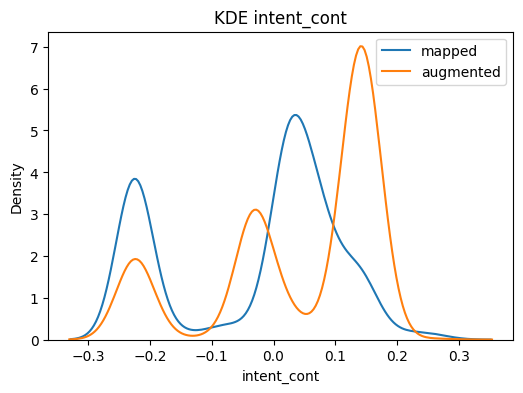

In [7]:
from scipy import stats as spstats

def cont_stats(series: pd.Series) -> dict:
    s = series.dropna()
    if len(s)==0: return {'mean':np.nan,'std':np.nan,'skew':np.nan,'kurt':np.nan,'iqr':np.nan}
    return {
        'mean': s.mean(),
        'std': s.std(ddof=1),
        'skew': spstats.skew(s),
        'kurt': spstats.kurtosis(s),
        'iqr': np.subtract(*np.percentile(s,[75,25]))
    }

cs = []
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    cs.append({'dataset': name, **cont_stats(df['intent_cont'])})
cont_df = pd.DataFrame(cs)
print(cont_df)

# KS test
mapped_c = mapped_n['intent_cont'].dropna()
aug_c = aug_n['intent_cont'].dropna()
if len(mapped_c)>0 and len(aug_c)>0:
    ks = spstats.ks_2samp(mapped_c, aug_c)
    print('KS Test D, p-value:', ks.statistic, ks.pvalue)
else:
    print('KS test non applicable (données manquantes).')

fig, ax = plt.subplots(figsize=(6,4))
for name, data in [('mapped', mapped_c), ('augmented', aug_c)]:
    if len(data)==0: continue
    sns.kdeplot(data, label=name, ax=ax)
ax.set_title('KDE intent_cont')
ax.legend(); plt.show()

## 8. Diversité Textuelle (Longueurs, TTR, Entropie)
Mesures de diversité sur prompts & responses (longueurs, TTR, MSTTR, hapax, entropie).

In [8]:
def token_stats(texts: pd.Series, window=100) -> dict:
    tokens = []
    for t in texts.dropna().astype(str):
        tokens.extend(t.split())
    if not tokens:
        return {'tokens':0,'types':0,'ttr':np.nan,'msttr':np.nan,'hapax_ratio':np.nan,'entropy_token':np.nan}
    types = set(tokens)
    ttr = len(types)/len(tokens)
    # MSTTR
    if len(tokens) < window:
        msttr = ttr
    else:
        segs = [tokens[i:i+window] for i in range(0, len(tokens)-window+1, window)]
        msttr = float(np.mean([len(set(seg))/len(seg) for seg in segs]))
    cnt = Counter(tokens)
    hapax_ratio = sum(1 for k,v in cnt.items() if v==1)/len(cnt)
    # Entropie tokens
    total = len(tokens)
    entropy_tok = -sum((v/total)*log2(v/total) for v in cnt.values())
    return {'tokens':len(tokens),'types':len(types),'ttr':ttr,'msttr':msttr,'hapax_ratio':hapax_ratio,'entropy_token':entropy_tok}

rows = []
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    for field in ['prompt','response']:
        st = token_stats(df[field])
        st['dataset']=name
        st['field']=field
        rows.append(st)
text_div = pd.DataFrame(rows)
text_div

,tokens,types,ttr,msttr,hapax_ratio,entropy_token,dataset,field
0,28910,9379,0.324421,0.784083,0.727476,10.713855,mapped,prompt
1,361746,59916,0.165630,0.765477,0.640046,11.858073,mapped,response
2,32428,4979,0.153540,0.730988,0.600121,9.084233,augmented,prompt
3,1592,1,0.000628,0.010000,0.000000,-0.000000,augmented,response


## 9. N-grammes Distincts & Overlap Inter-datasets
Extraction n-grammes (1-3) sur prompts, PMI simplifié, Jaccard overlap.

In [9]:
from itertools import islice

def ngrams(tokens, n):
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def top_ngrams(df: pd.DataFrame, n: int, top=20):
    all_tokens = [t.split() for t in df['prompt'].astype(str)]
    counter = Counter()
    for toks in all_tokens:
        counter.update(ngrams(toks, n))
    total = sum(counter.values())
    items = counter.most_common(top)
    return pd.DataFrame({'ngram':[k for k,_ in items], 'freq':[v for _,v in items], 'rel_freq':[v/total for _,v in items]})

for n in [1,2,3]:
    print(f"Top {n}-gram mapped")
    display(top_ngrams(mapped_n, n))
    print(f"Top {n}-gram augmented")
    display(top_ngrams(aug_n, n))

# Overlap Jaccard
jacc = []
for n in [1,2,3]:
    set_m = set().union(*[set(ngrams(t.split(), n)) for t in mapped_n['prompt'].astype(str)])
    set_a = set().union(*[set(ngrams(t.split(), n)) for t in aug_n['prompt'].astype(str)])
    inter = len(set_m & set_a); union = len(set_m | set_a)
    jacc.append({'n':n,'jaccard': inter/(union or 1), 'mapped_unique': len(set_m - set_a), 'aug_unique': len(set_a - set_m)})

pd.DataFrame(jacc)

Top 1-gram mapped


,ngram,freq,rel_freq
0,the,1188,0.041093
1,a,846,0.029263
2,to,802,0.027741
3,and,651,0.022518
4,of,548,0.018955
5,in,530,0.018333
6,for,384,0.013283
7,is,380,0.013144
8,I,356,0.012314
9,you,294,0.010169


Top 1-gram augmented


,ngram,freq,rel_freq
0,to,1727,0.053256
1,a,1544,0.047613
2,I,1198,0.036943
3,the,1058,0.032626
4,and,1024,0.031578
5,need,869,0.026798
6,for,842,0.025965
7,my,745,0.022974
8,help,538,0.016591
9,of,309,0.009529


Top 2-gram mapped


,ngram,freq,rel_freq
0,in the,133,0.004958
1,is the,109,0.004063
2,of the,102,0.003802
3,for a,67,0.002497
4,What is,67,0.002497
5,Can you,58,0.002162
6,me a,56,0.002087
7,what is,48,0.001789
8,to the,47,0.001752
9,for the,44,0.001640


Top 2-gram augmented


,ngram,freq,rel_freq
0,I need,790,0.025619
1,need to,454,0.014723
2,need help,364,0.011804
3,planning a,163,0.005286
4,trip to,156,0.005059
5,for a,153,0.004962
6,help me,138,0.004475
7,to find,136,0.004410
8,for next,135,0.004378
9,to my,134,0.004346


Top 3-gram mapped


,ngram,freq,rel_freq
0,What is the,38,0.001491
1,what is the,26,0.001020
2,How do I,18,0.000706
3,is the best,17,0.000667
4,you give me,16,0.000628
5,I want to,15,0.000588
6,How can I,15,0.000588
7,you tell me,15,0.000588
8,write me a,13,0.000510
9,What are the,12,0.000471


Top 3-gram augmented


,ngram,freq,rel_freq
0,I need to,413,0.014107
1,I need help,342,0.011682
2,need help planning,115,0.003928
3,need to find,115,0.003928
4,help planning a,112,0.003826
5,I want to,103,0.003518
6,you help me,94,0.003211
7,email to my,92,0.003142
8,to figure out,89,0.003040
9,need to figure,67,0.002288


,n,jaccard,mapped_unique,aug_unique
0,1,0.191634,7070,2670
1,2,0.071856,18203,11118
2,3,0.024254,23047,16862


## 10. Détection de Doublons Exactes
Groupements par prompt et par (prompt,response).

In [10]:
def exact_dup_report(df: pd.DataFrame, key_cols, label):
    grp = df.groupby(key_cols).size().reset_index(name='count')
    dups = grp[grp['count']>1].sort_values('count', ascending=False)
    pct = dups['count'].sum()/len(df)*100 if len(df)>0 else 0
    print(f"[{label}] {len(dups)} groupes dupliqués, {pct:.2f}% des lignes impliquées (clé={key_cols})")
    return dups.head(10)

print('Prompts duplications mapped:')
display(exact_dup_report(mapped_n, ['prompt'], 'mapped'))
print('Prompts duplications augmented:')
display(exact_dup_report(aug_n, ['prompt'], 'augmented'))
print('Couples duplications all:')
display(exact_dup_report(all_df, ['prompt','response','source'], 'all'))

Prompts duplications mapped:
[mapped] 4 groupes dupliqués, 0.38% des lignes impliquées (clé=['prompt'])


,prompt,count
99,Can you write a book?,2
315,How many days in February,2
575,Tell me a random fun fact about the Roman Empire,2
663,What is LinkedIn?,2


Prompts duplications augmented:
[augmented] 0 groupes dupliqués, 0.00% des lignes impliquées (clé=['prompt'])


,prompt,count


Couples duplications all:
[all] 0 groupes dupliqués, 0.00% des lignes impliquées (clé=['prompt', 'response', 'source'])


,prompt,response,source,count


## 11. Détection de Quasi-Doublons (Fuzzy / MinHash)
Approches RapidFuzz et MinHash LSH intra-dataset.

In [11]:
import itertools, string as _string

PUNCT_TABLE = str.maketrans('', '', _string.punctuation)

def normalize_simple(s: str) -> str:
    return s.lower().translate(PUNCT_TABLE).strip()

def fuzzy_pairs(df: pd.DataFrame, sample_max=200, score_threshold=90):
    if not HAVE_RAPIDFUZZ or len(df)<=1:
        return []
    sample = df.sample(min(sample_max, len(df)), random_state=RANDOM_SEED)
    res = []
    rows = sample.to_dict('records')
    for a, b in itertools.combinations(rows, 2):
        pa, pb = a['prompt'], b['prompt']
        if not pa or not pb: continue
        if abs(len(pa)-len(pb)) / max(len(pa),1) > 0.1: # blocage longueur
            continue
        sc = fuzz.token_set_ratio(pa, pb)
        if sc >= score_threshold:
            res.append({'id_a': a['id'], 'id_b': b['id'], 'score': sc})
    return res

fuzzy_results = []
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    pairs = fuzzy_pairs(df)
    print(name, 'quasi-doublons fuzzy détectés (échantillon):', len(pairs))
    fuzzy_results.extend([{'dataset':name, **p} for p in pairs])

fuzzy_df = pd.DataFrame(fuzzy_results)
if len(fuzzy_df):
    display(fuzzy_df.sort_values('score', ascending=False).head(10))
else:
    print('Aucun quasi-doublon fuzzy (conditions).')

# MinHash LSH intra (prompts)
if HAVE_DATASKETCH:
    def minhash_clusters(df: pd.DataFrame, sample_max=500):
        sample = df.sample(min(sample_max, len(df)), random_state=RANDOM_SEED)
        lsh = MinHashLSH(threshold=0.8, num_perm=64)
        hashes = {}
        for i, row in sample.iterrows():
            m = MinHash(num_perm=64)
            text = normalize_simple(row['prompt'])
            shingles = {text[j:j+5] for j in range(max(1,len(text)-4))}
            for sh in shingles:
                m.update(sh.encode('utf-8'))
            lsh.insert(str(i), m)
            hashes[str(i)] = (row['id'], m)
        # Regrouper
        clusters = []
        visited = set()
        for key, (rid, mh) in hashes.items():
            if key in visited: continue
            bucket = lsh.query(mh)
            visited.update(bucket)
            if len(bucket)>1:
                clusters.append([hashes[k][0] for k in bucket])
        return clusters
    for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
        clusters = minhash_clusters(df)
        print(name, 'clusters MinHash (échantillon):', len(clusters))
else:
    print('MinHash non disponible.')

mapped quasi-doublons fuzzy détectés (échantillon): 0
augmented quasi-doublons fuzzy détectés (échantillon): 0
Aucun quasi-doublon fuzzy (conditions).
mapped clusters MinHash (échantillon): 3
mapped clusters MinHash (échantillon): 3
augmented clusters MinHash (échantillon): 13
augmented clusters MinHash (échantillon): 13


## 12. Quasi-Doublons Inter-datasets (Variation de Formulation)
Recherche de correspondances cross-source (fuzzy ou LSH).

In [12]:
inter_matches = []
if HAVE_RAPIDFUZZ:
    sample_m = mapped_n.sample(min(150, len(mapped_n)), random_state=RANDOM_SEED)
    sample_a = aug_n.sample(min(150, len(aug_n)), random_state=RANDOM_SEED)
    for _, row_m in sample_m.iterrows():
        best = None
        for _, row_a in sample_a.iterrows():
            sc = fuzz.partial_ratio(row_m['prompt'], row_a['prompt'])
            if sc >= 92:
                inter_matches.append({'mapped_id':row_m['id'], 'aug_id':row_a['id'], 'score':sc, 'prompt_m':row_m['prompt'][:120], 'prompt_a':row_a['prompt'][:120]})
    inter_df = pd.DataFrame(inter_matches)
    print('Matches inter-datasets:', len(inter_df))
    display(inter_df.sort_values('score', ascending=False).head(10))
else:
    print('Fuzzy matching non disponible pour inter-datasets.')

Fuzzy matching non disponible pour inter-datasets.


## 13. (Optionnel) Similarité Sémantique Intra / Inter
Utilisation SentenceTransformer si disponible pour comparer distributions de similarités.

{'mean_intra_mapped': np.float64(0.07412092827446759), 'mean_intra_augmented': np.float64(0.07778419377282261), 'mean_inter': np.float64(0.0460102819558233)}


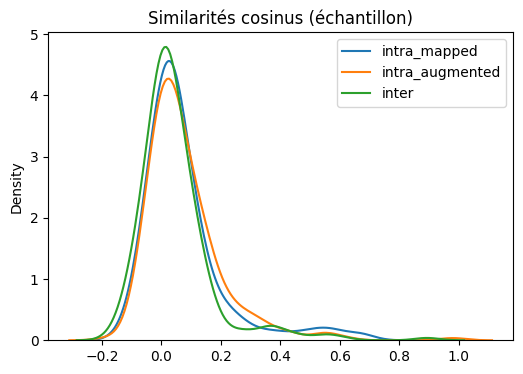

In [13]:
semantic_summary = {}
if HAVE_ST:
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    # Stratified sample by intent_disc if possible
    def strat_sample(df, per_intent=50):
        if df['intent_disc'].notna().any():
            parts = []
            for k, sub in df.groupby('intent_disc'):
                parts.append(sub.sample(min(per_intent, len(sub)), random_state=RANDOM_SEED))
            return pd.concat(parts).reset_index(drop=True)
        return df.sample(min(200, len(df)), random_state=RANDOM_SEED)
    mapped_s = strat_sample(mapped_n)
    aug_s = strat_sample(aug_n)
    emb_m = model.encode(mapped_s['prompt'].tolist(), show_progress_bar=False, normalize_embeddings=True)
    emb_a = model.encode(aug_s['prompt'].tolist(), show_progress_bar=False, normalize_embeddings=True)
    # Intra similarities (random pairs)
    def rand_pairs(emb, n=1000):
        sims = []
        if len(emb)<2: return sims
        idx = np.random.default_rng(RANDOM_SEED).choice(len(emb), size=(min(n, len(emb)),2), replace=True)
        for i,j in idx:
            if i==j: continue
            sims.append(float(np.dot(emb[i], emb[j])))
        return sims
    sims_m = rand_pairs(emb_m)
    sims_a = rand_pairs(emb_a)
    # Inter similarities
    inter_sims = []
    for i in range(min(1000, len(emb_m))):
        j = i % len(emb_a)
        inter_sims.append(float(np.dot(emb_m[i], emb_a[j])))
    semantic_summary = {
        'mean_intra_mapped': np.mean(sims_m) if sims_m else np.nan,
        'mean_intra_augmented': np.mean(sims_a) if sims_a else np.nan,
        'mean_inter': np.mean(inter_sims) if inter_sims else np.nan
    }
    print(semantic_summary)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(sims_m, label='intra_mapped', ax=ax)
    sns.kdeplot(sims_a, label='intra_augmented', ax=ax)
    sns.kdeplot(inter_sims, label='inter', ax=ax)
    ax.set_title('Similarités cosinus (échantillon)')
    ax.legend(); plt.show()
else:
    print('SentenceTransformer non disponible – section ignorée.')

## 14. (Optionnel) Clustering & Projection 2D
Projection UMAP + clustering HDBSCAN si embeddings disponibles.

/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/data-aug/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will 

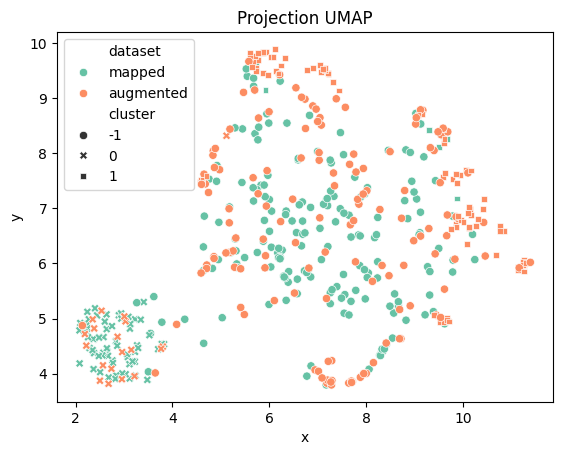

In [14]:
if HAVE_ST and HAVE_UMAP and HAVE_HDBSCAN and 'emb_m' in locals():
    emb_all = np.vstack([emb_m, emb_a])
    labels_src = (['mapped']*len(emb_m)) + (['augmented']*len(emb_a))
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_SEED)
    emb_2d = reducer.fit_transform(emb_all)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    cl_labels = clusterer.fit_predict(emb_all)
    df_plot = pd.DataFrame({'x':emb_2d[:,0],'y':emb_2d[:,1],'dataset':labels_src,'cluster':cl_labels})
    sns.scatterplot(df_plot, x='x', y='y', hue='dataset', style='cluster', palette='Set2')
    plt.title('Projection UMAP')
    plt.show()
else:
    print('Clustering non exécuté (dépendances ou embeddings manquants).')

## 15. Tableau de Synthèse des Métriques
Compilation des indicateurs clés et export CSV/JSON.

In [15]:
# Collecte métriques
synth_rows = []
# Dup pourcentage (exact prompt) sur each dataset
for name, df in [('mapped', mapped_n), ('augmented', aug_n)]:
    dup_prompt_pct = (df.duplicated(subset=['prompt']).mean())*100
    fuzzy_pct = np.nan
    if 'fuzzy_df' in locals() and len(fuzzy_df):
        fuzzy_pct = 100 * len(fuzzy_df[fuzzy_df['dataset']==name]) / len(df) if len(df) else np.nan
    ent_disc = entropy(Counter(df['intent_disc'].dropna().tolist()))
    mean_cont = df['intent_cont'].mean()
    # TTR prompt
    tstats_prompt = token_stats(df['prompt'])
    synth_rows.append({
        'dataset': name,
        'rows': len(df),
        'unique_intents': df['intent_disc'].nunique(dropna=True),
        'entropy_intent_disc': ent_disc,
        'mean_intent_cont': mean_cont,
        'ttr_prompt': tstats_prompt['ttr'],
        'hapax_prompt': tstats_prompt['hapax_ratio'],
        'dup_exact_prompt_pct': dup_prompt_pct,
        'quasi_dup_prompt_pct': fuzzy_pct,
        'mean_semantic_intra': semantic_summary.get(f'mean_intra_{name}', np.nan) if semantic_summary else np.nan
    })

synth_df = pd.DataFrame(synth_rows)
print(synth_df)
# Export
synth_df.to_csv(OUTPUT_DIR / 'comparative_metrics.csv', index=False)
synth_df.to_json(OUTPUT_DIR / 'comparative_metrics.json', orient='records', force_ascii=False)
print('Exports écrits dans', OUTPUT_DIR)

     dataset  rows  unique_intents  entropy_intent_disc  mean_intent_cont  \
0     mapped  2082               5             1.827317         -0.026732   
1  augmented  1592               5             2.097655          0.041217   

   ttr_prompt  hapax_prompt  dup_exact_prompt_pct  quasi_dup_prompt_pct  \
0    0.324421      0.727476              0.192123                   NaN   
1    0.153540      0.600121              0.000000                   NaN   

   mean_semantic_intra  
0             0.074121  
1             0.077784  
Exports écrits dans /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs


## 17. Thématisation des Prompts avec BERTopic
Analyse thématique automatisée des `prompt` pour comparer la couverture sémantique entre les datasets.

Objectifs:
- Extraire des topics cohérents (mots clés) via BERTopic.
- Mesurer la distribution des topics par dataset (mapped vs augmented).
- Identifier les topics sur / sous-représentés dans le dataset augmenté.
- Calculer métriques simples: nombre de topics, taille moyenne, diversité lexicale des topics.

Dépendances nécessaires: `bertopic`, `sentence-transformers`, `umap-learn`, `hdbscan`.
Si non installées: voir instructions imprimées dans la cellule de code.

## 18. Visualisations des Topics (Dataset Interne)

Cette section produit plusieurs visualisations des topics extraits sur vos `prompt` combinés (mapped + augmented):

Objectifs:
- Afficher la fréquence des topics les plus fréquents (hors bruit `-1`).
- Générer les visualisations interactives BERTopic (si l'extension `plotly` est disponible):
  - `visualize_topics`
  - `visualize_barchart`
  - `visualize_hierarchy`
  - `visualize_heatmap`
  - `visualize_documents`
- Sauvegarder les figures interactives en HTML dans `outputs/` pour consultation hors notebook.

Si `topic_model` n'existe pas (non exécuté en section 17), un modèle minimal sera ré-entraîné automatiquement (sans OpenAI) pour produire les graphiques.

topic_model absent – ré-entraînement minimal (sans OpenAI)...


,Topic,Count,Name
1,0,290,0_to_and_the_for
2,1,72,1_0098947947513_0065965298342_00824566229275_end
3,2,62,2_recipe_cook_chicken_make
4,3,50,3_write_poem_about_story
5,4,46,4_les_de_plus_bougies
6,5,41,5_lu分解的详细流程是怎样的_请具体解释_人类基因组上的m染色体是什么_如何支持女朋友处理被闺蜜背叛的情感问题
7,6,36,6_1000000_量子点在医学成像中的应用有哪些_如何设计一个适合初学者的每周运动计划_需要结合自己的教学实例
8,7,35,7_无法满足数据输入的请求_无法满足正态性假设时_查询cloves综合征的诊治方法_相较于其他算法有何优势
9,8,34,8_travel_trip_destinations_hotels
10,9,34,9_weather_today_temperature_what


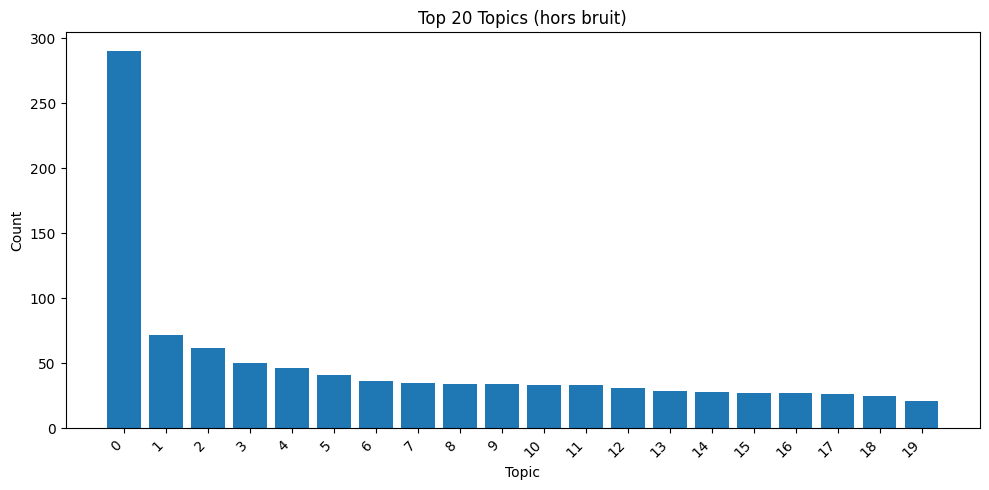

Sauvé: /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs/bertopic_viz/topics_overview.html
Sauvé: /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs/bertopic_viz/topics_barchart.html
Sauvé: /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs/bertopic_viz/topics_hierarchy.html
Sauvé: /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs/bertopic_viz/topics_heatmap.html
visualize_documents non disponible: list index out of range
Visualisations terminées. Fichiers HTML dans: /Users/mathiscarlesso/Documents/Cesi/Alteca/Thèse/Agent_Dataaug/outputs/bertopic_viz


In [16]:
# Visualisations des topics
import math
from pathlib import Path

# Vérifier la présence du modèle
if 'topic_model' not in globals() or topic_model is None:
    print("topic_model absent – ré-entraînement minimal (sans OpenAI)...")
    try:
        from bertopic import BERTopic
        from bertopic.representation import KeyBERTInspired
        if HAVE_ST:
            embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        else:
            embedding_model = None
        mini_prompts = all_df['prompt'].dropna().astype(str).tolist()[:2000]
        topic_model = BERTopic(embedding_model=embedding_model, language="multilingual", verbose=False)
        topics, probs = topic_model.fit_transform(mini_prompts)
    except Exception as e:
        print("Impossible de ré-entraîner un modèle minimal:", e)

if 'topic_model' in globals() and topic_model is not None:
    info = topic_model.get_topic_info()
    if len(info) == 0:
        print("Aucun topic disponible.")
    else:
        # Filtrer bruit (-1)
        info_no_noise = info[info.Topic != -1].copy()
        top_k = info_no_noise.head(20)
        display(top_k[['Topic','Count','Name']])

        # Bar chart statique (matplotlib)
        try:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10,5))
            ax.bar(top_k['Topic'].astype(str), top_k['Count'])
            ax.set_title('Top 20 Topics (hors bruit)')
            ax.set_xlabel('Topic')
            ax.set_ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Bar chart matplotlib échoué:", e)

        # Dossier sortie
        html_dir = OUTPUT_DIR / 'bertopic_viz'
        html_dir.mkdir(exist_ok=True, parents=True)

        # Fonctions helper pour sauvegarde interactive
        def save_plotly(fig, name):
            try:
                out = html_dir / f"{name}.html"
                fig.write_html(str(out))
                print(f"Sauvé: {out}")
            except Exception as e:
                print(f"Echec sauvegarde {name}:", e)

        # Visualisations interactives (si plotly dispo)
        try:
            viz_topics = topic_model.visualize_topics()
            save_plotly(viz_topics, 'topics_overview')
        except Exception as e:
            print("visualize_topics non disponible:", e)
        try:
            viz_bar = topic_model.visualize_barchart(top_n_topics=20)
            save_plotly(viz_bar, 'topics_barchart')
        except Exception as e:
            print("visualize_barchart non disponible:", e)
        try:
            viz_hier = topic_model.visualize_hierarchy()
            save_plotly(viz_hier, 'topics_hierarchy')
        except Exception as e:
            print("visualize_hierarchy non disponible:", e)
        try:
            viz_heat = topic_model.visualize_heatmap()
            save_plotly(viz_heat, 'topics_heatmap')
        except Exception as e:
            print("visualize_heatmap non disponible:", e)
        try:
            # Limiter les docs pour la lisibilité
            subset_prompts = prompts_all[:100] if 'prompts_all' in globals() else all_df['prompt'].dropna().astype(str).tolist()[:100]
            topics_subset, _ = topic_model.transform(subset_prompts)
            viz_docs = topic_model.visualize_documents(subset_prompts, topics_subset)
            save_plotly(viz_docs, 'topics_documents_subset')
        except Exception as e:
            print("visualize_documents non disponible:", e)

        print("Visualisations terminées. Fichiers HTML dans:", html_dir)
else:
    print("Pas de topic_model disponible pour visualisation.")

In [17]:
try:
    from bertopic import BERTopic
    from bertopic.representation import KeyBERTInspired, OpenAI
    from openai import OpenAI as OpenAIClient
    HAVE_BERTOPIC = True
except ImportError:
    HAVE_BERTOPIC = False
    print("BERTopic ou OpenAI non installé. Exécutez: pip install bertopic openai")
    print("Pour les visualisations interactives: pip install 'bertopic[visualization]'")

if HAVE_BERTOPIC and HAVE_ST and HAVE_UMAP and HAVE_HDBSCAN:
    print("Dépendances pour BERTopic chargées.")
    
    # 1. Préparation des données
    prompts_all = all_df['prompt'].dropna().astype(str).tolist()
    source_labels = all_df.loc[all_df['prompt'].notna(), 'source'].tolist()
    
    # 2. Modèle d'embedding (réutilisation de la section 13)
    embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # 3. Modèles de réduction et clustering
    umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=RANDOM_SEED)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # 4. Représentation des topics
    # Modèle de base
    keybert_model = KeyBERTInspired()
    
    # (Optionnel) Modèle OpenAI / OpenRouter
    # Assurez-vous que la variable d'environnement OPENROUTER_API_KEY est définie
    if 'OPENROUTER_API_KEY' in os.environ and os.environ['OPENROUTER_API_KEY']:
        print("Utilisation d'OpenRouter pour la labellisation des topics.")
        client = OpenAIClient(
            base_url="https://openrouter.ai/api/v1",
            api_key=os.environ.get("OPENROUTER_API_KEY"),
        )
        # Modèle pour générer des labels de topics concis
        prompt_template = "Je dois nommer un topic à partir de ces mots-clés: [KEYWORDS]. Le nom doit être très concis (3-4 mots max) et en français."
        
        # Correction: Initialiser OpenAI, puis définir les attributs
        openrouter_model = OpenAI(
            client,
            # Le modèle est un argument de la classe
            model="openai/gpt-oss-20b", 
            # Le prompt est un argument de la classe
            prompt=prompt_template,
            chat=True,
            nr_docs=5
        )
        
        # Combinez les deux représentations
        representation_model = {
            "KeyBERT": keybert_model,
            "OpenRouter": openrouter_model
        }
    else:
        print("OPENROUTER_API_KEY non trouvée ou vide. Utilisation de KeyBERT seul.")
        representation_model = keybert_model

    # 5. Création et entraînement du modèle BERTopic
    topic_model = BERTopic(
      embedding_model=embedding_model,
      umap_model=umap_model,
      hdbscan_model=hdbscan_model,
      representation_model=representation_model,
      verbose=True,
      language="multilingual" # Pour prendre en compte les prompts en FR/EN/CN
    )

    topics, probs = topic_model.fit_transform(prompts_all)
    
    # 6. Analyse des résultats
    print("\nInformations sur le modèle de topics:")
    display(topic_model.get_topic_info())

    # Visualisation de la distribution des topics par dataset
    topics_per_source = topic_model.topics_per_class(prompts_all, classes=source_labels)
    
    # Afficher la comparaison des topics entre 'mapped' et 'augmented'
    # On se concentre sur les topics les plus fréquents dans chaque classe
    display(topic_model.visualize_topics_per_class(topics_per_source, top_n_topics=10))

else:
    print("Analyse BERTopic non exécutée car des dépendances sont manquantes.")
    print(f"BERTopic: {HAVE_BERTOPIC}, SentenceTransformer: {HAVE_ST}, UMAP: {HAVE_UMAP}, HDBSCAN: {HAVE_HDBSCAN}")

Dépendances pour BERTopic chargées.


2025-08-28 16:36:08,396 - BERTopic - Embedding - Transforming documents to embeddings.


Utilisation d'OpenRouter pour la labellisation des topics.


Batches: 100%|██████████| 115/115 [00:05<00:00, 19.89it/s]
2025-08-28 16:36:14,206 - BERTopic - Embedding - Completed ✓
2025-08-28 16:36:14,207 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm

2025-08-28 16:36:14,206 - BERTopic - Embedding - Completed ✓
2025-08-28 16:36:14,207 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-28 16:36:28,269 - BERTopic - Dimensionality - Completed ✓
2025-08-28 16:36:28,270 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-28 16:36:28,269 - BERTopic - Dimensionality - Completed ✓
2025-08-28 16:36:28,270 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-28 16:36:28,349 - BERTopic - Cluster - Completed ✓
2025-08-28 16:36:28,352 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-28 16:36:28,349 - BERTopic - Cluster - Completed ✓
2025-08-28 16:36:28,352 - BERTopic - Representation - Fine-tuning topics using representat


Informations sur le modèle de topics:


,Topic,Count,Name,Representation,KeyBERT,OpenRouter,Representative_Docs
0,-1,1104,-1_the_is_of_how,"[the, is, of, how, what, to, and, in, can, you]","[data, email, project, using, use, create, need, message, write, text]",[Mots fonctionnels français],[create some excel sheet heads for me to record data: the important settings that we need to check when running the study\nthe file names for the eye tracki...
1,0,109,0_flight_york_book_angeles,"[flight, york, book, angeles, los, next, from, new, hotel, find]","[flights, flight, airline, airlines, angeles, los, booking, airport, york, tickets]",[],"[I need to book a flight from New York to Los Angeles for next week., I need to book a flight from New York to Los Angeles for next weekend, can you help me..."
2,1,68,1_weather_forecast_weekend_today,"[weather, forecast, weekend, today, temperature, seattle, like, know, tomorrow, this]","[weather, forecast, seattle, weekend, tomorrow, rain, precipitation, washington, portland, denver]",[**Météo week‑end Seattle**],"[Tell me about the weather forecast for this weekend in Seattle., I want to know the weather forecast for this weekend in Seattle., I need to know the weath..."
3,2,66,2_0098947947513_0065965298342_00824566229275_end,"[0098947947513, 0065965298342, 00824566229275, end, m1, python, 0131930596684, int, library, increment]","[python, dplyr, calculate_average, num_perm, increment, min_ngram_size, tuple, ngram_size, dict, heatmap]",[**Manipulation de données Python**],[为什么我run不出来：library(dplyr) # for data wrangling\nlibrary(tidyr)\nlibrary(ggplot2) # for plots\nlibrary(magrittr) # for pipe %>%\nlibrary(MASS)\nlibrary(...
4,3,65,3_experience_resume_as_position,"[experience, resume, as, position, role, skills, team, letter, job, and]","[resume, roles, role, hiring, cv, skills, recruiter, interview, experience, apply]",[],"[IDRIS OLATUNJI AMODU\n\n57, Shaw Road, Bromley, United Kingdom.\nMobile No.: +447438423801\nEmail: tunji.IA4@gmail.com\n\n\n\nPERSONAL STATEMENT\n\nI am lo..."
...,...,...,...,...,...,...,...
93,92,11,92_insert_prompt_specified_catchy,"[insert, prompt, specified, catchy, details, title, story, book, style, write]","[novels, summary, summarize, writing, title, book, write, books, subject, paragraph]",[],"[Create a catchy subject title., I want to read a detailed summary before I commit to buying a book, but I don't want to accidentally see any major spoilers..."
94,93,10,93_sleepwalk_stress_head_migraine,"[sleepwalk, stress, head, migraine, girlfriends, tinnitus, oversleeping, treating, motivated, banged]","[relax, sleep, remedies, stress, tips, tinnitus, sleepwalk, relief, oversleeping, techniques]",[],"[What are some ways to relax/de-stress after a long work day?, I just banged my head with my girlfriends head what should I do because it hurts, How are peo..."
95,94,10,94_遗传因素是否会影响不孕不育_而不需要我亲自调试_老板不发工钱已读不回_朋友说工作压力有点大,"[遗传因素是否会影响不孕不育, 而不需要我亲自调试, 老板不发工钱已读不回, 朋友说工作压力有点大, 提前多少时间订机票会最便宜, 我该怎么回复, 我不想工作怎么办, 头晕不止应该怎么办, 哪些编程错误能加快错误检测速度, 告诉我]","[亚特兰大什么时候会下雪, 不孕不育会遗传吗, 遗传因素是否会影响不孕不育, 而不需要我亲自调试, 提前多少时间订机票会最便宜, 我不想工作怎么办, 朋友说工作压力有点大, 我该怎么回复, 头晕不止应该怎么办, 告诉我]",[**Questions de vie quotidienne**],"[哪些编程错误能加快错误检测速度，而不需要我亲自调试？, 朋友说工作压力有点大，我该怎么回复, 告诉我，亚特兰大什么时候会下雪？]"
96,95,10,95_万物互联等概念内涵及其应用场景_你能分享几个关键要素_葡萄胎是怎样形成的_能推荐几个成都的必去旅游景点吗,"[万物互联等概念内涵及其应用场景, 你能分享几个关键要素, 葡萄胎是怎样形成的, 能推荐几个成都的必去旅游景点吗, 研究背景生成的步骤是什么, 生成对抗网络, 游戏吸引大众吗, 概括鸿蒙生态, 有哪些主要类别, 数据哈希生成的安全最佳实践是什么]","[你能推荐个好用的ai生成图片软件, 研究背景生成的步骤是什么, 让ai生成内容, 数据哈希生成的安全最佳实践是什么, 生成对抗网络, 能推荐几个成都的必去旅游景点吗, 怎么养成储蓄的好习惯, 葡萄胎是怎样形成的, 使用summon命令生成血量为5的苦力怕, 概括鸿蒙生态]",[],"[概括鸿蒙生态，万物互联等概念内涵及其应用场景, 生成对抗网络(GAN)有哪些主要类别？, 你能分享几个关键要素，让AI生成内容(AIGC)游戏吸引大众吗？]"


2it [00:00, 15.50it/s]

